### [04/20/22] CIFAR10 ResNet20 Sweep Batch Size, Learning Rate, and Warmup

In [1]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.exps import TrainExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("colorblind"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
def get_accuracy_val(exp, num_reps, object_store):
    exp_hash = utils.get_hash(exp.name)
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        object_store.download_object(f"{bucket_dir}/{exp_hash}/replicate_{rep}/main/log.txt", "temp.txt")
        log = pd.read_table("temp.txt", header=None)[0]
        os.remove("temp.txt")
        steps_t, accs_t = [], []
        for line in log:
            match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
            if match:
                steps_t.append(int(match.group(1)))
                accs_t.append(float(match.group(2)))
        steps_rt.append(steps_t)
        accs_rt.append(accs_t)
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [3]:
config = f"../configs/lr_data_warm_cf10_rn20/bs128.yaml"
num_replicates = 4
exp = TrainExperiment.create(f=config, cli_args=False)
lrs_bs128 = [0.1, 0.2, 0.4, 0.8, 1.6]
accs_bs128 = []
for lr in tqdm(lrs_bs128):
    exp.optimizer.lr = lr
    _, accs_rt = get_accuracy_val(exp, num_replicates, object_store)
    accs_bs128.append(accs_rt[:, -1])
accs_bs128 = np.array(accs_bs128)

100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


In [4]:
config = f"../configs/lr_data_warm_cf10_rn20/bs1024.yaml"
num_replicates = 4
exp = TrainExperiment.create(f=config, cli_args=False)
lrs_bs1024 = [0.2, 0.4, 0.8, 1.6, 3.2]
accs_bs1024 = []
for lr in tqdm(lrs_bs1024):
    exp.optimizer.lr = lr
    _, accs_rt = get_accuracy_val(exp, num_replicates, object_store)
    accs_bs1024.append(accs_rt[:, -1])
accs_bs1024 = np.array(accs_bs1024)

100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


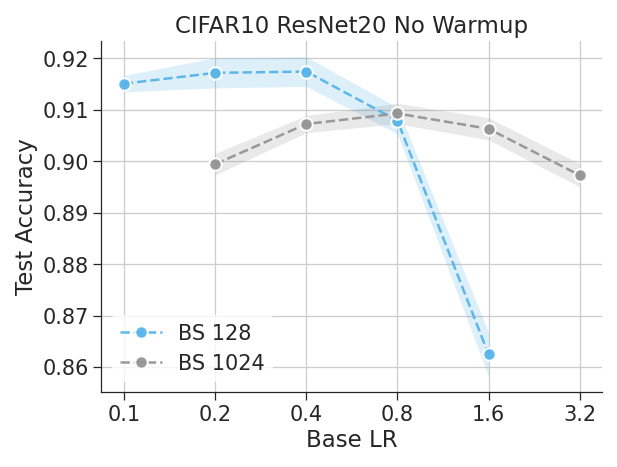

In [5]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
x, ys, c = np.array(lrs_bs128), accs_bs128, "C9"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x*10), ym, c=c, ls="--", marker="o", alpha=0.95)
ls.append(l[0])
ax.fill_between(np.log2(x*10), ym+ye, ym-ye, color=c, alpha=0.2)
x, ys, c = np.array(lrs_bs1024), accs_bs1024, "C7"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x*10), ym, c=c, ls="--", marker="o", alpha=0.95)
ls.append(l[0])
ax.fill_between(np.log2(x*10), ym+ye, ym-ye, color=c, alpha=0.2)
ax.legend(ls, ["BS 128", "BS 1024"], fontsize=10, loc=3)
ax.set_xticks([0, 1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.8, 1.6, 3.2])
ax.set_xlabel("Base LR")
ax.set_ylabel("Test Accuracy")
ax.set_title("CIFAR10 ResNet20 No Warmup")
fig.show()

In [6]:
config = f"../configs/lr_data_warm_cf10_rn20/bs1024_warmup.yaml"
num_replicates = 8
exp = TrainExperiment.create(f=config, cli_args=False)
lrs_warm = [0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
warmups = [100, 200, 400, 800, 1600, 3200]
accs_wl = []
for warmup in tqdm(warmups):
    accs_l = []
    for lr in lrs_warm:
        exp.optimizer.lr = lr
        exp.schedulers[0].t_warmup = f"{warmup}ba"
        _, accs_rt = get_accuracy_val(exp, num_replicates, object_store)
        accs_l.append(accs_rt[:, -1])
    accs_wl.append(accs_l)
accs_wl = np.array(accs_wl)

100%|██████████| 6/6 [02:33<00:00, 25.66s/it]


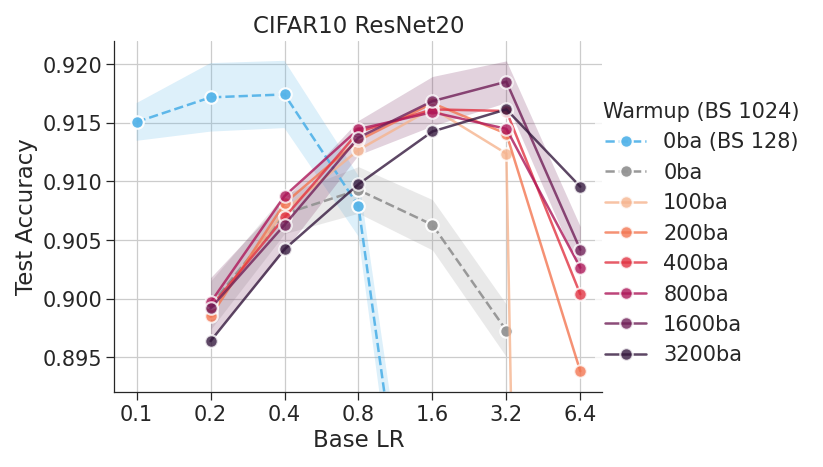

In [10]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
x, ys, c = np.array(lrs_bs128), accs_bs128, "C9"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x*10), ym, c=c, ls="--", marker="o", alpha=0.95)
ls.append(l[0])
ax.fill_between(np.log2(x*10), ym+ye, ym-ye, color=c, alpha=0.2)
x, ys, c = np.array(lrs_bs1024), accs_bs1024, "C7"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x*10), ym, c=c, ls="--", marker="o", alpha=0.95)
ls.append(l[0])
ax.fill_between(np.log2(x*10), ym+ye, ym-ye, color=c, alpha=0.2)
x, ys, cs = np.array(lrs_warm), accs_wl, sns.color_palette("rocket_r", n_colors=len(warmups))
ym, ye = ys.mean(-1), ys.std(-1)
for w in range(len(warmups)):
    l = ax.plot(np.log2(x*10), ym[w], c=cs[w], marker="o", alpha=4/5)
    ls.append(l[0])
ax.fill_between(np.log2(x*10), ym[-2]+ye[-2], ym[-2]-ye[-2], color=cs[-2], alpha=0.2)
plt.ylim(0.892, 0.922)
fig.legend(
    ls, 
    [
        "0ba (BS 128)",
        "0ba",
        "100ba",
        "200ba",
        "400ba",
        "800ba",
        "1600ba",
        "3200ba",
    ], 
    bbox_to_anchor=(0.96, 0.5), 
    loc="center left", 
    fontsize=10,
    title="Warmup (BS 1024)",
    title_fontsize=10,
)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6], [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4])
ax.set_xlabel("Base LR")
ax.set_ylabel("Test Accuracy")
ax.set_title("CIFAR10 ResNet20")
fig.show()